In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../../San_Juan_train.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)

In [3]:
nb_variables = {'window': 4, 'shift': -1}

In [4]:
print('------ Basic Stats about the San Juan Training set ------ \n')
print(f'- Number of rows of the training set: {len(df)} \n')
print(f'- Number of columns of the training set: {len(df.columns)}, where the last on is the label \n')
perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- Percentage of missing values across the entire dataset {perc}% \n')
url = 'https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/'
print(f'- Description for all variables can be found here: {url} \n')

------ Basic Stats about the San Juan Training set ------ 

- Number of rows of the training set: 936 

- Number of columns of the training set: 23, where the last on is the label 

- Percentage of missing values across the entire dataset 1.77% 

- Description for all variables can be found here: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/ 



In [5]:
for col in df.columns[:-1]: # exclude the label variable
    df[col] = df[col].fillna(df.rolling(window = nb_variables['window'],
                                        min_periods = 1).mean()[col])
new_perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- The amount of NAs was reduced to {new_perc}% \n')
print('- For the next step we will fill the remaining NAs with zeroes \n')

df = df.fillna(0)
new_perc = np.round(100 * df.isna().sum().sum() / (len(df) * len(df.columns)), 2)
print(f'- The amount of NAs was reduced to {new_perc}% \n')
print(f'- We are ready to make predictions! \n')

- The amount of NAs was reduced to 0.21% 

- For the next step we will fill the remaining NAs with zeroes 

- The amount of NAs was reduced to 0.0% 

- We are ready to make predictions! 



# - Turn the problem into a supervised one
This is done by shifting the data to one or more steps into the future and using X, Y, X(t+1) variables to predict Y(t+1)

In [6]:
df_tp1 = df.shift(nb_variables['shift']).iloc[:nb_variables['shift'], :]

In [7]:
for i in range(len(df_tp1.columns)):
    df_tp1.rename(columns = {(df_tp1.columns[i]) : (df_tp1.columns[i] + '_tp1')}, inplace = True)

In [8]:
df_tp1

,year_tp1,weekofyear_tp1,ndvi_ne_tp1,ndvi_nw_tp1,ndvi_se_tp1,ndvi_sw_tp1,precipitation_amt_mm_tp1,reanalysis_air_temp_k_tp1,reanalysis_avg_temp_k_tp1,reanalysis_dew_point_temp_k_tp1,...,reanalysis_relative_humidity_percent_tp1,reanalysis_sat_precip_amt_mm_tp1,reanalysis_specific_humidity_g_per_kg_tp1,reanalysis_tdtr_k_tp1,station_avg_temp_c_tp1,station_diur_temp_rng_c_tp1,station_max_temp_c_tp1,station_min_temp_c_tp1,station_precip_mm_tp1,total_cases_tp1
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0
1990-05-07,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0
1990-05-14,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0
1990-05-21,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0
1990-05-28,1990.0,23.0,0.119028,0.174850,0.254314,0.181743,9.58,299.630000,299.764286,295.851429,...,79.891429,9.58,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-18,2008.0,13.0,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,...,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4.0
2008-03-25,2008.0,14.0,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,...,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3.0
2008-04-01,2008.0,15.0,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,...,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1.0


In [9]:
new_df = pd.concat([df.iloc[:-1, :], df_tp1], axis = 1)
new_df.index = pd.to_datetime(new_df.index)

In [10]:
new_df.shape

(935, 46)

## Important: we are dropping that variable because it's not available at the test set!

In [11]:
new_df.drop('total_cases', inplace = True, axis = 1)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
train_amount = 0.8
df_x_train = new_df.iloc[:int(train_amount * len(new_df)), : -1]
df_x_test = new_df.iloc[int(train_amount * len(new_df)):, : -1]

df_x_train = scaler.fit_transform(X = df_x_train)
df_x_test = scaler.transform(X = df_x_test)

df_y_train = new_df.iloc[:int(train_amount * len(new_df)), -1]
df_y_test = new_df.iloc[int(train_amount * len(new_df)):, -1]

- Save scaler to use it on test data

In [14]:
pickle.dump(scaler, open('../models/sj_scaler', "wb"))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [16]:
opt = Adam(learning_rate = 5e-5)

model = Sequential()
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = opt, loss='mae')

In [17]:
def lr_scheduler(epoch, lr):
    if epoch <= 40:
        return lr
    else:
        return lr * 0.98

In [18]:
# -- Checkpoints -- #
lr_scheduler = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 75, restore_best_weights=True, mode = 'min')
checkpoint = ModelCheckpoint(monitor = 'val_loss', filepath = '../models/sj_mlp.keras', save_best_only = True, 
                             mode = 'min', save_freq = 'epoch')

In [19]:
history = model.fit(df_x_train, df_y_train, batch_size = 4, validation_data = (df_x_test, df_y_test), epochs=150, verbose=2,
                   use_multiprocessing = True, callbacks = [checkpoint, lr_scheduler])

Epoch 1/150


2023-01-27 17:59:45.890948: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


187/187 - 1s - loss: 36.5791 - val_loss: 24.7054 - lr: 5.0000e-05 - 1s/epoch - 6ms/step
Epoch 2/150
187/187 - 0s - loss: 36.4329 - val_loss: 24.8156 - lr: 5.0000e-05 - 276ms/epoch - 1ms/step
Epoch 3/150
187/187 - 0s - loss: 36.3355 - val_loss: 24.7837 - lr: 5.0000e-05 - 269ms/epoch - 1ms/step
Epoch 4/150
187/187 - 0s - loss: 36.2361 - val_loss: 24.6294 - lr: 5.0000e-05 - 290ms/epoch - 2ms/step
Epoch 5/150
187/187 - 0s - loss: 36.1621 - val_loss: 24.6083 - lr: 5.0000e-05 - 290ms/epoch - 2ms/step
Epoch 6/150
187/187 - 0s - loss: 36.0471 - val_loss: 24.4345 - lr: 5.0000e-05 - 295ms/epoch - 2ms/step
Epoch 7/150
187/187 - 0s - loss: 35.9599 - val_loss: 24.3349 - lr: 5.0000e-05 - 293ms/epoch - 2ms/step
Epoch 8/150
187/187 - 0s - loss: 35.8208 - val_loss: 24.1589 - lr: 5.0000e-05 - 293ms/epoch - 2ms/step
Epoch 9/150
187/187 - 0s - loss: 35.6732 - val_loss: 24.0712 - lr: 5.0000e-05 - 294ms/epoch - 2ms/step
Epoch 10/150
187/187 - 0s - loss: 35.6468 - val_loss: 23.9892 - lr: 5.0000e-05 - 296ms/e

187/187 - 0s - loss: 25.8740 - val_loss: 19.1901 - lr: 2.2740e-05 - 264ms/epoch - 1ms/step
Epoch 81/150
187/187 - 0s - loss: 26.1494 - val_loss: 19.1316 - lr: 2.2285e-05 - 265ms/epoch - 1ms/step
Epoch 82/150
187/187 - 0s - loss: 25.8898 - val_loss: 19.2123 - lr: 2.1839e-05 - 263ms/epoch - 1ms/step
Epoch 83/150
187/187 - 0s - loss: 25.9948 - val_loss: 19.1316 - lr: 2.1403e-05 - 264ms/epoch - 1ms/step
Epoch 84/150
187/187 - 0s - loss: 25.8446 - val_loss: 19.3726 - lr: 2.0974e-05 - 265ms/epoch - 1ms/step
Epoch 85/150
187/187 - 0s - loss: 25.7115 - val_loss: 19.2694 - lr: 2.0555e-05 - 262ms/epoch - 1ms/step
Epoch 86/150
187/187 - 0s - loss: 25.7731 - val_loss: 19.4787 - lr: 2.0144e-05 - 262ms/epoch - 1ms/step
Epoch 87/150
187/187 - 0s - loss: 25.8720 - val_loss: 19.4366 - lr: 1.9741e-05 - 265ms/epoch - 1ms/step
Epoch 88/150
187/187 - 0s - loss: 25.7445 - val_loss: 19.0379 - lr: 1.9346e-05 - 283ms/epoch - 2ms/step
Epoch 89/150
187/187 - 0s - loss: 25.7852 - val_loss: 19.3717 - lr: 1.8959e-0

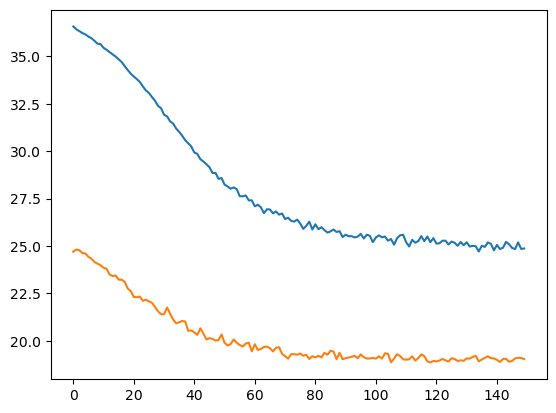

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [21]:
predictions = model.predict(df_x_test)
predictions = np.round(predictions).astype('int32')
predictions[predictions < 0] = 0
predictions.shape

6/6 [==============================] - 0s 943us/step


(187, 1)

Train Dataset MAE: 20.143670107809776


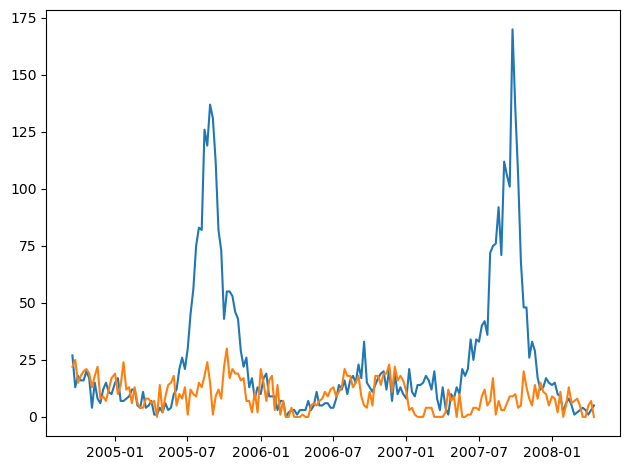

In [22]:
dataset_mae = np.mean(np.abs(predictions - df_y_test.values))
print(f'Train Dataset MAE: {dataset_mae}')
plt.plot(df_y_test);
plt.plot(df_y_test.index, predictions);
plt.tight_layout();